<a href="https://colab.research.google.com/github/ParasKaole20/Gesture-Recognition-using-ML/blob/main/Gesture%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
gesture_zip = "/content/drive/MyDrive/Datasets/Gestures.zip"
lip_zip = "/content/drive/My Drive/Datasets/Lip data.zip"
extract_path = "/content/dataset"

# Extract files
with zipfile.ZipFile(gesture_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

with zipfile.ZipFile(lip_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Datasets extracted successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Datasets extracted successfully!


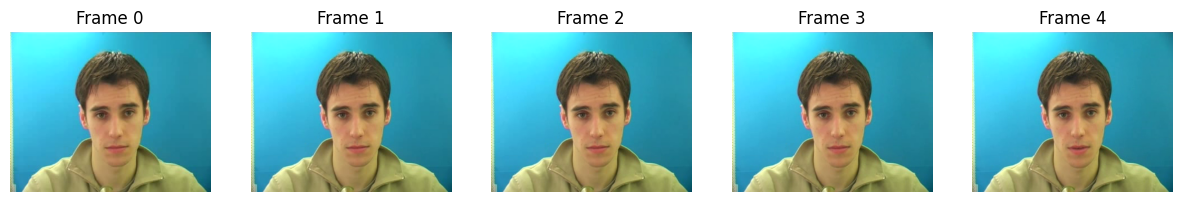

In [ ]:
import cv2
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(sample_video)
frame_count = 0

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

while cap.isOpened() and frame_count < 5:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    axes[frame_count].imshow(frame)
    axes[frame_count].set_title(f"Frame {frame_count}")
    axes[frame_count].axis("off")
    frame_count += 1

cap.release()
plt.show()


In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2  # Extract the file


--2025-02-03 08:29:31--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-02-03 08:29:31--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  34.9MB/s    in 1.7s    

2025-02-03 08:29:33 (34.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



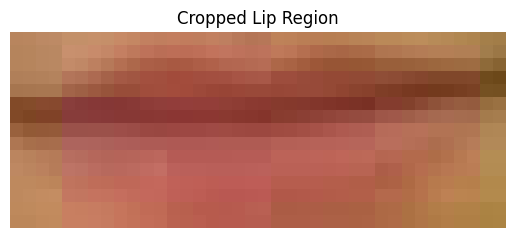

In [ ]:
import dlib
import numpy as np

# Load face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Download needed

def extract_lip_region(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)

        # Extract lip coordinates (points 48-67)
        lip_points = np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(48, 68)])

        # Create bounding box
        x_min, y_min = np.min(lip_points, axis=0)
        x_max, y_max = np.max(lip_points, axis=0)
        lip_region = frame[y_min:y_max, x_min:x_max]

        return lip_region  # Cropped mouth region
    return None

# Extract and show cropped lips from one frame
cap = cv2.VideoCapture(sample_video)
ret, frame = cap.read()
cap.release()

if ret:
    lip_crop = extract_lip_region(frame)
    if lip_crop is not None:
        plt.imshow(cv2.cvtColor(lip_crop, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Lip Region")
        plt.axis("off")
        plt.show()
    else:
        print("No face detected.")


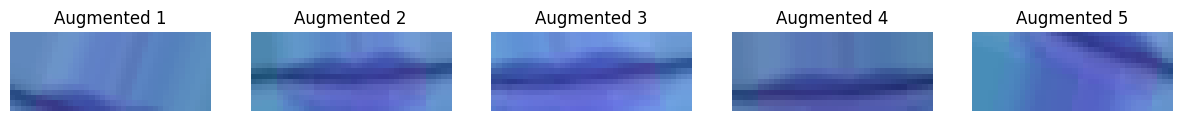

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Initialize ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=20,         # Random rotation
    width_shift_range=0.2,     # Random horizontal shift
    height_shift_range=0.2,    # Random vertical shift
    shear_range=0.2,           # Shear transformation
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Random horizontal flip
    brightness_range=[0.8, 1.2]  # Random brightness adjustment
)

# Generate augmented images
lip_augmented = datagen.flow(np.expand_dims(lip_crop, axis=0), batch_size=1)

# Show 5 augmented versions of the lip region
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, _ in enumerate(range(5)):
    augmented_image = next(lip_augmented)[0].astype(np.uint8)
    axes[i].imshow(augmented_image)
    axes[i].set_title(f"Augmented {i+1}")
    axes[i].axis("off")
plt.show()


In [ ]:
gesture_images = []
gesture_labels = []

# Iterate through each folder and process images
for class_name in os.listdir('/content/dataset/leapGestRecog/09/'):
    class_folder = os.path.join('/content/dataset/leapGestRecog/09/', class_name)

    if os.path.isdir(class_folder):
        print(f"Processing class: {class_name}")

        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)

            # Make sure it's a valid image file
            if img_name.lower().endswith('.png'):
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Error reading image: {img_path}")
                    continue  # Skip unreadable images

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, (64, 64))  # Resize image (you can adjust this size)

                gesture_images.append(img)
                gesture_labels.append(class_name)  # Use the folder name as the label (string)

# Now, gesture_images and gesture_labels should contain the processed images and labels
print(f"Processed {len(gesture_images)} images.")


Processing class: 04_fist_moved
Processing class: 06_index
Processing class: 05_thumb
Processing class: 09_c
Processing class: 03_fist
Processing class: 10_down
Processing class: 01_palm
Processing class: 08_palm_moved
Processing class: 02_l
Processing class: 07_ok
Processed 2000 images.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator with augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,       # Rotatimg images randomly by up to 30 degrees
    width_shift_range=0.2,   # Randomly shifting images horizontally by 20%
    height_shift_range=0.2,  # Randomly shifting images vertically by 20%
    shear_range=0.2,         # Apply shear transformations
    zoom_range=0.2,          # Zoom in or out by up to 20%
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill missing pixels with nearest pixel value
)

# Convert the gesture images to a numpy array
import numpy as np
gesture_images = np.array(gesture_images)

# Reshape images for the generator (assuming the images are 64x64x3)
gesture_images = gesture_images.reshape((-1, 64, 64, 3))

# Apply the augmentation and generate augmented images
augmented_images = []
augmented_labels = []

for img, label in zip(gesture_images, gesture_labels):
    img = img.reshape((1,) + img.shape)  # Reshape for the generator
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype(np.uint8))  # Convert back to uint8
        augmented_labels.append(label)
        i += 1
        if i > 10:  # Generate 10 augmented images per original image
            break

# Convert augmented lists back to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(f"Total augmented images: {len(augmented_images)}")


Total augmented images: 22000


In [ ]:
from sklearn.model_selection import train_test_split

# Spliting the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 17600
Testing set size: 4400


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()

# Fit the encoder on all unique labels
label_encoder.fit(np.concatenate((y_train, y_test)))

# Transform the labels to numerical values
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now use the encoded labels for to_categorical
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')  # Output layer with the number of unique labels
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,410 (6.20 MB)

 Trainable params: 1,625,410 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Adjust this to 10 classes
])


In [ ]:
num_classes = len(np.unique(augmented_labels))
print(f"Number of classes: {num_classes}")


Number of classes: 10


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [78]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


NotImplementedError: numpy() is only available when eager execution is enabled.

In [ ]:

test_loss, test_acc = model.evaluate(X_test, y_test)

]
print(f"Test Accuracy: {test_acc}")


138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9656 - loss: 0.1311
Test Accuracy: 0.9659090638160706


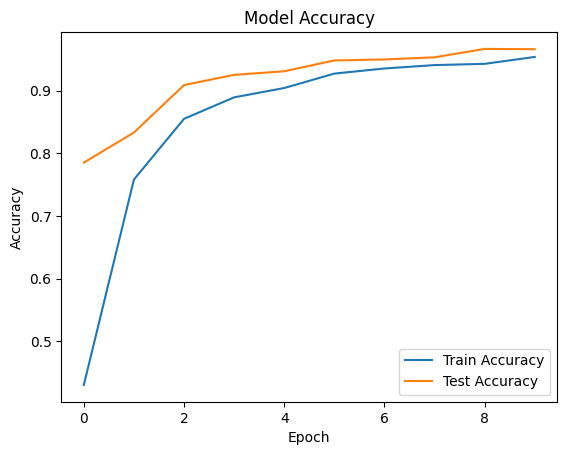

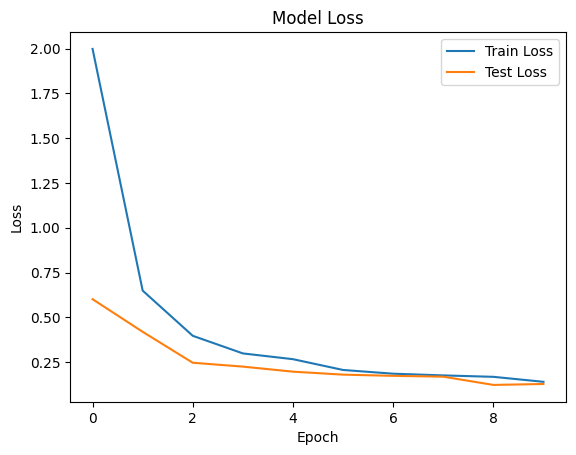

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Save the trained model to a file
model.save('gesture_recognition_model.h5')


**INFERENCE**

In [ ]:
from keras.models import load_model
model = load_model('gesture_recognition_model.h5')


In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    # Convert to RGB (since the model expects RGB images)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize to the input size the model expects
    img = cv2.resize(img, (64, 64))  # (64, 64) should match your model's input size
    # Normalize the image (assuming the model was trained on normalized images)
    img = img / 255.0
    # Reshape the image to (1, 64, 64, 3) for prediction
    img = np.expand_dims(img, axis=0)
    return img


In [ ]:
def predict_gesture(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)

    # Map the predicted class to the gesture label (you can define these labels)
    gesture_labels = ['fist_moved', 'index', 'thumb', 'palm', 'down', 'ok', 'c', 'palm_moved', 'l', 'palm']

    # Output the predicted gesture
    print(f"Predicted Gesture: {gesture_labels[predicted_class]}")


In [ ]:
cap = cv2.VideoCapture('path_to_video.mp4')

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess and predict on the current frame
    img = preprocess_image(frame)
    prediction = model.predict(img)

    predicted_class = np.argmax(prediction)
    print(f"Predicted Gesture: {gesture_labels[predicted_class]}")

    # Optionally, display the frame with the prediction
    cv2.putText(frame, f"Gesture: {gesture_labels[predicted_class]}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Gesture Recognition', frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [64]:
image_path = '/content/WhatsApp Image 2025-02-03 at 16.14.39_3ff4b4e1.jpg'  # Provide the path to an image
predict_gesture(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Gesture: palm_moved


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


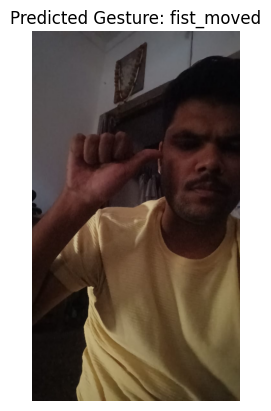

Predicted Gesture: fist_moved


In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Replace with the correct path
image_path = '/content/fist.jpg'  # Use the correct path

# Load the image
image = cv2.imread(image_path)

# Check if image is loaded correctly
if image is None:
    print(f"Error: Could not load image at {image_path}")
else:
    # Continue with the processing
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (64, 64))  # Resize image to match model input size
    image_normalized = image_resized / 255.0  # Normalize the image
    image_input = np.expand_dims(image_normalized, axis=0)  # Add batch dimension

    # Predict the gesture
    predictions = model.predict(image_input)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Mapping predicted class to gesture label
    gesture_labels = ['palm', 'thumb', 'fist', 'down', 'index', 'ok', 'palm_moved', 'fist_moved', 'l', 'c']  # Ensure this matches your class labels
    predicted_gesture = gesture_labels[predicted_class]

    # Show the image with the predicted gesture
    plt.imshow(image_rgb)
    plt.title(f"Predicted Gesture: {predicted_gesture}")
    plt.axis('off')  # Hide axes
    plt.show()

    print(f"Predicted Gesture: {predicted_gesture}")
